In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import netCDF4 as nc
import datetime as dt

In [2]:
# Load in netcdf4 file
f = nc.Dataset('./templates/MUR_SST-Pre2020.nc')
f

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): lat(35), lon(32), time(3653)
    variables(dimensions): float32 lat(lat), float32 lon(lon), int64 time(time), int16 analysed_sst(time, lat, lon)
    groups: 

In [3]:
# Create a blank dataframe
df = pd.DataFrame()

inter = f.variables['time'][:]

# Iterate through each time step
for i in range(1, len(inter) + 1):
    # 'i' is measure of days since 2002-06-01, utilize timedelta to convert to datetime
    date = dt.datetime(2002, 6, 1) + dt.timedelta(days=int(inter[i-1]))
    
    # Change to yyyymmdd format
    date = date.strftime('%Y%m%d')
    
    # If month is not '201010' for first 6 numbers, skip
    
    # For this particular array in the netcdf file, find the average of all values
    average = np.mean(f.variables['analysed_sst'][i - 1]) - 273.15
    
    # Add date, average to dataframe using concat
    df = pd.concat([df, pd.DataFrame({'date': [date], 'average': [average]})], ignore_index=True)
    
    # df

df

,date,average
0,20100101,27.697560
1,20100102,27.980149
2,20100103,28.007204
3,20100104,28.043740
4,20100105,27.776867
...,...,...
3648,20191228,27.739370
3649,20191229,27.619013
3650,20191230,27.464221
3651,20191231,27.350554


In [4]:
# load 1985-2019_mmm_observed.nc
f2 = nc.Dataset('./templates/1985-2019_mmm_observed.nc')

# Take this nc file and create a numpy array
f3 = f2.variables['variable'][:] - 0.4
print(type(f3))

# Find the average of all values in the netcdf file, but ignore Nan values
average = np.nanmean(f3) + 1

average

<class 'numpy.ma.core.MaskedArray'>


29.003128051757812

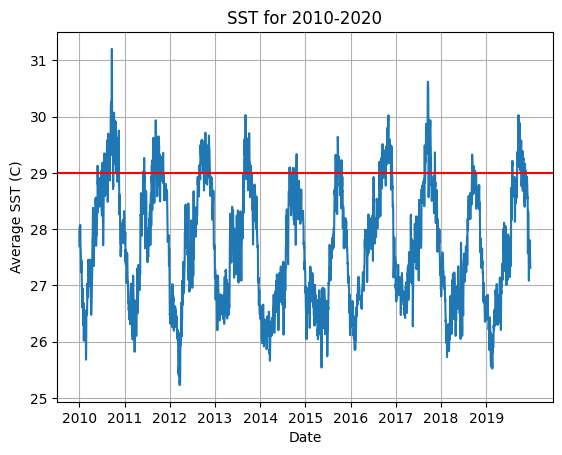

In [5]:
# Print date vs average, only showing the year
plt.plot(df['date'], df['average'])

# x-labels
dates = df['date'][::366] # Convert the dates, to only show the year
# Convert dates to list
dates = dates.to_list()
#print(dates)
# Set xticks to only show the year
dates = [(str(dates[i]))[0:4] for i in range(len(dates))]
#print(dates)

# Set as xticks
plt.xticks(df['date'][::366], dates)

# Plot the 'average' as a horizontal line
plt.axhline(y=average, color='r', linestyle='-')

# set x and y var
plt.xlabel('Date')
plt.ylabel('Average SST (C)')
plt.title('SST for 2010-2020')
plt.grid()

In [6]:
import datetime
import configparser as cp
import os

In [7]:
# Read the configuration file
config = cp.ConfigParser()
config.read('../config.ini')
print('Loaded in successfully')

Loaded in successfully


In [8]:
# Load in data for MUR SST pre 2020
path = config['settings']['MUR_pre2020'][1:]
path = f'..{path}'
path2 = '../data/refined/HRCS_nc/1985-2019_mmm_observed.nc'

# Load in mur data
mur = nc.Dataset(path)

# load in HRCS data
hrcs = nc.Dataset(path2)

print("Successful")

Successful


In [9]:
# Match the dimension of the two datasets, the latitude and longitude should be in the same range.
# Read the latitude and longitude values from the hrcs dataset
hrcs_lat = hrcs.variables['lat'][:]
hrcs_lon = hrcs.variables['lon'][:]

# Find the min and max of the latitude and longitude values
lat_min = hrcs_lat.min()
lat_max = hrcs_lat.max()
lon_min = hrcs_lon.min()
lon_max = hrcs_lon.max()

# Read the latitude and longitude values from the mur dataset
mur_lat = mur.variables['lat'][:]
mur_lon = mur.variables['lon'][:]

# Find the indices in the mur dataset that correspond to the hrcs ranges
lat_inds = np.where((mur_lat >= lat_min) & (mur_lat <= lat_max))[0]
lon_inds = np.where((mur_lon >= lon_min) & (mur_lon <= lon_max))[0]

# Use these indices to slice the mur dataset
mursst = mur.variables['analysed_sst'][:, lat_inds, lon_inds]

# Retrieve a list of the dates from the mur dataset
mursstdates = mur.variables['time'][:]

mur.close()

# Load hrcs to numpy array.
hrcs_sst = (hrcs.variables['variable'][:, :])
hrcs.close()

print("Successfully Changed Data")

Successfully Changed Data


In [10]:
print(f'Time: {mursst.shape[0]}, Lat: {mursst.shape[1]}, Lon: {mursst.shape[2]}')
print(hrcs_sst.shape)

Time: 3653, Lat: 30, Lon: 24
(30, 24)


In [11]:
# Load mur mmm nc file
path3 = '../data/refined/mur_mmm.nc'
mur_mmm = nc.Dataset(path3)

# Match the dimension of the two datasets, the latitude and longitude should be in the same range.
lat_inds = np.where((mur_mmm['lat'][:] >= lat_min) & (mur_mmm['lat'][:] <= lat_max))[0]
lon_inds = np.where((mur_mmm['lon'][:] >= lon_min) & (mur_mmm['lon'][:] <= lon_max))[0]
calculatedmmmsst = mur_mmm['mmm_sst'][:, lat_inds, lon_inds]

# Retrieve a list of labels for the time dimension
calculatedmmmssttime = mur_mmm['time'][:]

# Convert to list
calculatedmmmssttime = calculatedmmmssttime.tolist()

# Convert every item to an int
calculatedmmmssttime = [str(int(i)) for i in calculatedmmmssttime]

# Close
mur_mmm.close()

print(len(calculatedmmmssttime), type(calculatedmmmssttime))
print(calculatedmmmsst.shape, type(calculatedmmmsst))
print(calculatedmmmssttime)

156 <class 'list'>
(156, 30, 24) <class 'numpy.ma.core.MaskedArray'>
['202001', '202002', '202003', '202004', '202005', '202006', '202007', '202008', '202009', '202010', '202011', '202012', '202101', '202102', '202103', '202104', '202105', '202106', '202107', '202108', '202109', '202110', '202111', '202112', '202201', '202202', '202203', '202204', '202205', '202206', '202207', '202208', '202209', '202210', '202211', '202212', '201001', '201002', '201003', '201004', '201005', '201006', '201007', '201008', '201009', '201010', '201011', '201012', '201101', '201102', '201103', '201104', '201105', '201106', '201107', '201108', '201109', '201110', '201111', '201112', '201201', '201202', '201203', '201204', '201205', '201206', '201207', '201208', '201209', '201210', '201211', '201212', '201301', '201302', '201303', '201304', '201305', '201306', '201307', '201308', '201309', '201310', '201311', '201312', '201401', '201402', '201403', '201404', '201405', '201406', '201407', '201408', '201409', 

In [12]:
# For loop going through each 'time' step in mursst
number = 0

# Current working directory
folder = './testfolder/'

# Create folder if not existed
if not os.path.exists(folder):
    os.makedirs(folder)

# delete all items in ./data/
for root, dirs, files in os.walk(f'{folder}'):
    for file in files:
        os.remove(os.path.join(root, file))

    
# Load the hrcs data
locationhrcs = '../data/refined/HRCS_nc/1985-2019_mmm_observed.nc'
hrcs = nc.Dataset(locationhrcs).variables['variable'][:] - 1

# bleaching threshold is hrcs plus one
bleachingthreshold = hrcs + 1
    
for day in range(83, mursst.shape[0]):
    # Initialize countsim
    contsim = True
    
    # Make numpy array for weekly heat stress
    totalheatstress = np.zeros((mursst.shape[1], mursst.shape[2]))
    
    # Read in the date from mursst
    date = datetime.datetime(2002, 6, 1) + datetime.timedelta(days=int(mursstdates[day]))
    
    # Convert date to string, with only year and month
    dateymd = date.strftime('%Y%m%d')
    
    
    for i in range(84):
        # Check to see if day-84 is less than 0, skip and set contsim to false. otherwise create dailyheatstress
        if day - 84 < 0:
            contsim = False
            break
        else:
            dailyheatstress = ((mursst[day - i, :, :] - 273.14) - bleachingthreshold)
            #print(dailyheatstress)
        
        # Add 1 to the array
        # dailyheatstress += 1
        
        # Replace any values that are below 1 in dailyheatstress with np nan
        dailyheatstress[dailyheatstress < 0] = 0
        
        # Add dailyheatstress to totalheatstress
        totalheatstress += dailyheatstress
        
    if contsim:
        # Replace any values that are 0 with np.nan
        totalheatstress[totalheatstress == 0] = np.nan
        
        # Divide totalheatstress by 7 and round to 2 decimal places
        totalheatstress = (totalheatstress/7).round(2)
        
        # convert totalheatstress to a dataframe
        totalheatstress = pd.DataFrame(totalheatstress)
        
        # save as csv in ./data/{dateym}.csv
        totalheatstress.to_csv(f'{folder}{dateymd}.csv', index=False)

print(f'All files saved in {folder}')

All files saved in ./testfolder/


In [13]:
# Create a blank dataframe, with coluimns 'date' and 'dhw'
df_avg = pd.DataFrame(columns=['date', 'dhw'])
df_max = pd.DataFrame(columns=['date', 'dhw'])

# Load in data from 'folder' and cycle through all of them
for item in os.listdir(folder):
    date = item[:-4]
    
    # Load in csv file as a numpy array
    data = pd.read_csv(f'{folder}{item}')
    
    # Find the maximum value of the data
    maximum = data.max().max()
    
    # Find the average of the non nan values
    average = data.stack().mean()
    
    # Concatenate the date and average to the dataframe
    df_avg = pd.concat([df_avg, pd.DataFrame({'date': [date], 'dhw': [average]})], ignore_index=True)
    df_max = pd.concat([df_max, pd.DataFrame({'date': [date], 'dhw': [maximum]})], ignore_index=True)

# Sort the dataframe by date
df_avg = df_avg.sort_values('date')
df_max = df_max.sort_values('date')

# Save the dataframe as a csv file
df_avg.to_csv('./csvfiles/v2_avg.csv', index=False)
df_max.to_csv('./csvfiles/v2_max.csv', index=False)

Text(0.5, 1.0, 'DHW for 2010-2011')

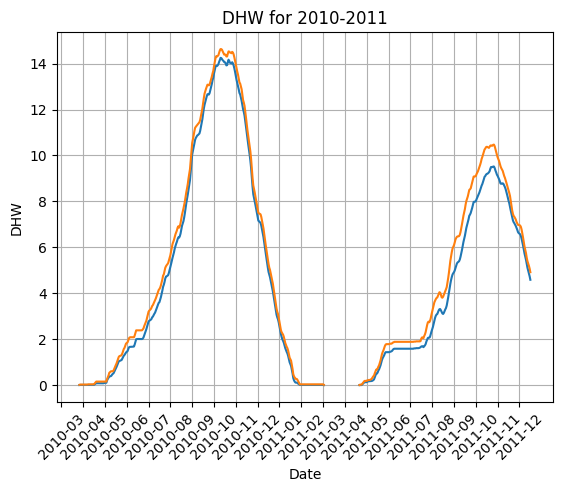

In [14]:
# Filter df_avg for 2010 or 2011 dates only
df_avg_new = df_avg.loc[df_avg['date'].str.startswith(('2010', '2011'))]

# Filter df_max for 2010 or 2011 dates only
df_max_new = df_max.loc[df_max['date'].str.startswith(('2010', '2011'))]

# Plot both the average and maximum values
plt.plot(df_avg_new['dhw'], label='Average')
plt.plot(df_max_new['dhw'], label='Maximum')

# Set the xticks to be the months


plt.grid()
plt.xlabel('Date')
plt.ylabel('DHW')
plt.title('DHW for 2010-2011')

Text(0.5, 1.0, 'Maximum DHW for 2011')

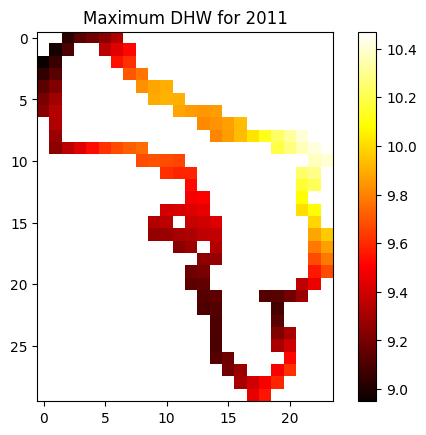

In [15]:
# Specify Year
year = "2011"

# Cycle through all dates in "./testfolder", only listing the dates that start with 'year'
list_of_files = [f for f in os.listdir(folder) if f.startswith(year)]

# Load first item in list of files to get the shape
first_item = pd.read_csv(f'{folder}{list_of_files[0]}')

# Create a 3d numpy array of zeros, with the shape of the length of list_of_files, and the shape of the first item
final_array = np.zeros((len(list_of_files), first_item.shape[0], first_item.shape[1]))

# Cycle through all items in list_of_files, and add them to the final_array
for i, item in enumerate(list_of_files):
    final_array[i] = pd.read_csv(f'{folder}{item}')

# Replace all np.nan values with 0
final_array = np.nan_to_num(final_array)

# Find the maximum in each index of y, z in the final_array
max_array = np.max(final_array, axis=0)

# Replace the 0 values with np.nan
max_array[max_array == 0] = np.nan

# Plot this
plt.imshow(max_array, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title(f'Maximum DHW for {year}')

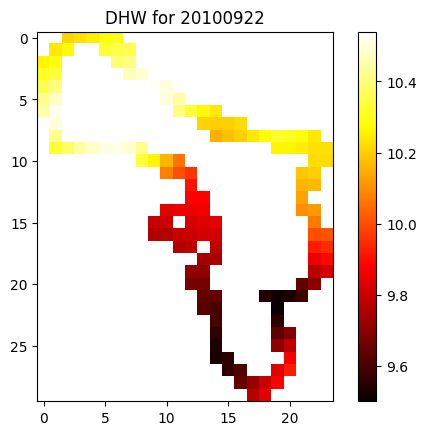

In [16]:
# Graph a specific day. Load the following date:
date = '20100922'
csvfilename = f'{folder}{date}.csv'

# Load in the csv file and plot it
data = pd.read_csv(csvfilename)
plt.imshow(data, cmap='hot', interpolation='nearest')

# Add a title
plt.title(f'DHW for {date}')

# show scale
plt.colorbar()